# **AutoDS**

---

<font size = 4> Deep-STORM is a neural network capable of image reconstruction from high-density single-molecule localization microscopy (SMLM), first published in 2018 by [Nehme *et al.* in Optica](https://www.osapublishing.org/optica/abstract.cfm?uri=optica-5-4-458). The architecture used here is a U-Net based network without skip connections. This network allows image reconstruction of 2D super-resolution images, in a supervised training manner. The network is trained using simulated high-density SMLM data for which the ground-truth is available. These simulations are obtained from random distribution of single molecules in a field-of-view and therefore do not imprint structural priors during training. The network output a super-resolution image with increased pixel density (typically upsampling factor of 8 in each dimension).

<font size = 4> AutoDS is an extension of Deep-STORM automating the reconstruction process and aleviating the need in human intervension. This is done by automatic detection of the experimental condition in the analyzed videos and automatic selection of a Deep-STORM model out of a set of pre-trained model for the data processing.

<font size = 4> Additionally, AutoDS pipeline splits each input frame into patches and enables processing of different regions in the field-of-view with different models. This mechanism led to an improvment in the reconstruction quality beyond the capabilities of Deep-STORM.


# **Before getting started**
---
<font size = 4> This notebook contains the code required only for inference of SMLM data using a set of pre-trained Deep-STORM models. For model training please follow this link: <font color = red> (add a link)

# **Run configuration**
---
<font size = 4>**`Data_folder`:** This folder should contain the images that you want to use your trained network on for processing.

<font size = 4>**`Result_folder`:** This folder will contain the found localizations csv.

<font size = 4>**`threshold`:** This paramter determines threshold for local maxima finding. The value is expected to reside in the range **[0,1]**. A higher `threshold` will result in less localizations. **DEFAULT: 0.1**

<font size = 4>**`neighborhood_size`:** This paramter determines size of the neighborhood within which the prediction needs to be a local maxima in recovery pixels (CCD pixel/upsampling_factor). A high `neighborhood_size` will make the prediction slower and potentially discard nearby localizations. **DEFAULT: 3**

<font size = 4>**`use_local_average`:** This paramter determines whether to locally average the prediction in a 3x3 neighborhood to get the final localizations. If set to **True** it will make inference slightly slower depending on the size of the FOV. **DEFAULT: True**

<font size = 4>**`num_patches`:** Determines the number of patches in each row and each column after splitting the frames to patches. The total number of patches will be num_patches<sup>2</sup>. **DEFAULT: 4**

<font size = 4>**`prediction_model_path`:** Specify the folder where the reconstruction will be saved. **DEFAULT: 4**

<font size = 4>**`batch_size`:** This paramter determines how many frames are processed by any single pass on the GPU. A higher `batch_size` will make the prediction faster but will use more GPU memory. If an OutOfMemory (OOM) error occurs, decrease the `batch_size`. **DEFAULT: 4**

<font size = 4>**The following parameters are relevant only if `interpolate_based_on_imaging_parameters` is checked:**

<font size = 4> - **`pixel_size`:** the pixels size of the analyzed video. **DEFAULT: 107**

<font size = 4> - **`wavelength`:** the emission wavelength of the analyzed video. **DEFAULT: 665**

<font size = 4> - **`numerical_aperture`:** the optical setup numerical aperture of the analyzed video. **DEFAULT: 1.49**

# **Mount Google Drive**
---
Running the next cell will mount your google drive

In [1]:
#@markdown Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **One-click inference**
---
Running the next cell will perform the following steps:
1. Installating require dependencies
2. Requesting GPU access
3. Running the inference based on your configuration

--------------------------------
DeepSTORM+ installation complete.
You have GPU access
Tensorflow version is 2.18.0
Loaded images: 484x540 with 2072 frames
Extracted global features
Selecting DeepSTORM model for each patch


100%|██████████| 2072/2072 [00:37<00:00, 55.71it/s]


[7.0612e+04 0.0000e+00 3.0000e+00 6.1993e+04]


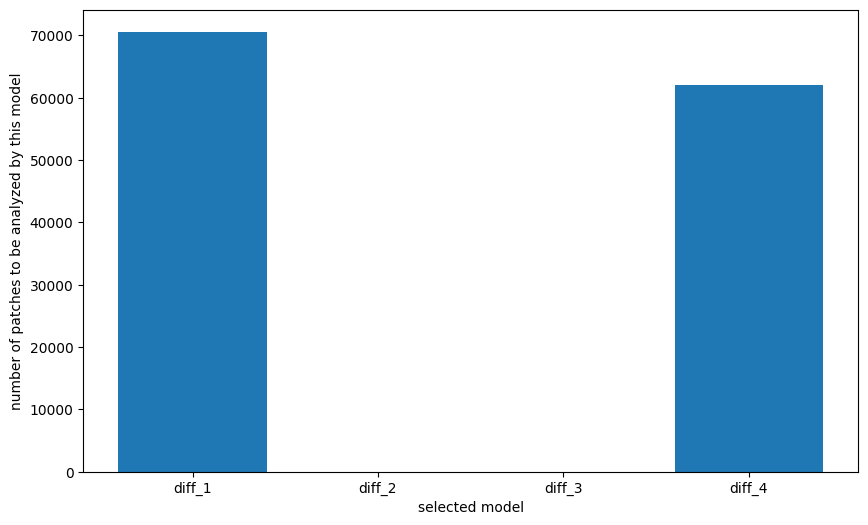

Analyzing patches for each model
The diff_1 model will be used.
Using local averaging


100%|██████████| 17653/17653 [19:50<00:00, 14.83it/s]


The diff_2 model will be used.
Using local averaging
The diff_3 model will be used.
Using local averaging


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


The diff_4 model will be used.
Using local averaging


100%|██████████| 15499/15499 [17:01<00:00, 15.17it/s]


--------------------------------------------------------------------
---------------------------- Previews ------------------------------
--------------------------------------------------------------------


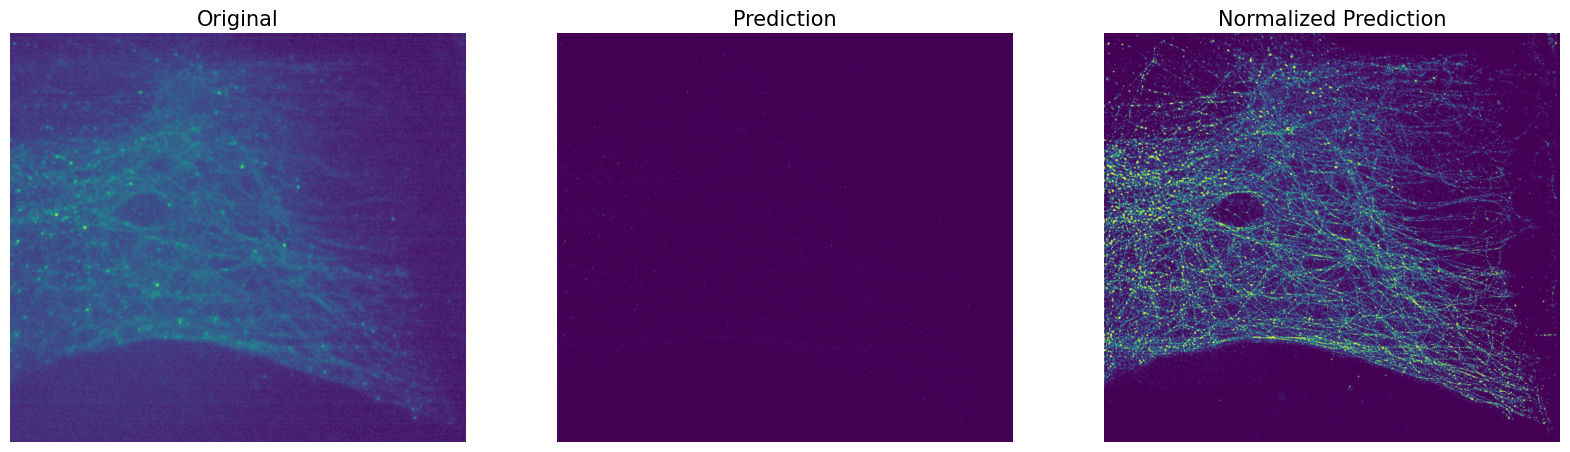

In [8]:
Notebook_version = '2.0'
Network = 'AutoDS'

# Import keras modules and libraries from tensorflow.keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, UpSampling2D, Conv2D, MaxPooling2D, BatchNormalization, Layer
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam

# Other libraries
import scipy.optimize as opt
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
import h5py
import cv2
from skimage import io
import os
import csv
from PIL import Image
from PIL.TiffTags import TAGS
import math
from skimage.feature import peak_local_max
from scipy.ndimage import gaussian_filter, zoom
from tqdm import tqdm

# Create a variable to get and store relative base path
base_path = os.getcwd()

def gaussian_interpolation_batch(data_batch, scale, sigma=1):
    """
    Applies Gaussian interpolation (smoothing and upsampling) to a batch of images.

    Parameters:
    - data_batch: A numpy array of shape (batch_size, height, width), where each entry is an image.
    - scale: The scaling factor for upsampling.
    - sigma: The standard deviation for the Gaussian filter (default is 1).

    Returns:
    - upsampled_data_batch: A numpy array containing the upsampled images.
    """
    upsampled_data_batch = []

    for data in data_batch:
        # Apply Gaussian filter to each image in the batch
        smoothed_data = gaussian_filter(data, sigma=sigma)

        # Upsample the smoothed image
        upsampled_data = zoom(smoothed_data, scale, order=3)  # Using cubic interpolation for smooth upsampling
        upsampled_data_batch.append(upsampled_data)

    # Convert the list of upsampled images back into a numpy array
    return np.array(upsampled_data_batch)

def interpolate_frames(tiff_stack, model_pixel_size, current_pixel_size, model_wavelength, current_wavelength, model_NA, current_NA):
    if(model_pixel_size is None):
        model_pixel_size = current_pixel_size
        print("Could not find the trained model pixel size - assuming: model pixel size = current pixel size")
    if(model_wavelength is None):
        model_wavelength = current_wavelength
        print("Could not find the trained model wavelength - assuming: model wavelength = current wavelength")
    if(model_NA is None):
        model_NA = current_NA
        print("Could not find the trained model NA - assuming: model NA = current NA")
    if(current_wavelength is None):
        model_wavelength = current_wavelength = 1
        print("Wavelength was not specified - ignoring parameter")
    if(current_NA is None):
        model_NA = current_NA = 1
        print("NA was not specified - ignoring parameter")

    ratio = (current_pixel_size * current_wavelength / current_NA )/(model_pixel_size * model_wavelength / model_NA)

    if len(tiff_stack.shape) == 2:
      tiff_stack = tiff_stack[None, :, :]
    N, H, W = tiff_stack.shape
    interpolated_stack = np.zeros([N, int(H * ratio), int(W * ratio)], dtype=np.float32)

    for frame in range(N):
        interpolated_stack[frame] = cv2.resize(tiff_stack[frame].astype(np.uint16), (int(W * ratio), int(H * ratio)),
                                               interpolation=cv2.INTER_CUBIC)
    return interpolated_stack

def ChooseNetByDifficulty_2025(density, SNR):
    num_models = 4
    norm_density = np.max([np.min([int(np.round(2 * density)), num_models-1]), 0])
    norm_SNR = num_models - 1 - np.max([np.min([SNR//6 - 2, num_models - 1]), 0])
    return int(np.round((norm_SNR + norm_density) / 2))

def reconstruct_patches_2025(Images, patch_ind, frame_numbers, weights_file, num_patches, overlap, number_of_frames,
                             thresh=0.1, neighborhood_size=3, use_local_avg=False, L2_weighting_factor=100,
                             upsampling_factor=8, pixel_size=None, batch_size=1):
    pixel_size_hr = pixel_size / upsampling_factor

    # Convert Images to float32 Tensor and move to GPU
    Images = tf.convert_to_tensor(Images, dtype=tf.float32)
    if Images.ndim == 2:
        Images = tf.expand_dims(Images, axis=0)  # Ensure 3D shape
    K_frames, M, N = Images.shape

    # Determine dimensions of each predicted (cropped) patch.
    patch_height = M * upsampling_factor - 2 * overlap
    patch_width = N * upsampling_factor - 2 * overlap

    # Create full image tensor on GPU
    reconstructed_image = np.zeros((patch_height * num_patches, patch_width * num_patches), dtype=np.float32)

    # Prepare lists for detections
    recon_xind, recon_yind, frame_index, confidence_list = [], [], [], []

    # Load the model on the GPU
    with tf.device('/GPU:0'):
        model = build_model_upsample((M, N, 1), lr=1e-3, upsampling_factor=upsampling_factor)
        model.load_weights(weights_file)

        # Create the post-processing layer
        max_layer = Maximafinder(thresh * L2_weighting_factor, neighborhood_size, use_local_avg)

        n_batches = int(np.ceil(K_frames / batch_size))
        for b in tqdm(range(n_batches)):
            start = b * batch_size
            end = min(K_frames, start + batch_size)
            nF = end - start

            # --- Move input batch to GPU ---
            batch_imgs = Images[start:end]  # Shape: (nF, M, N)

            # Use TensorFlow functions instead of NumPy for GPU efficiency
            imgs_means = tf.reduce_mean(batch_imgs, axis=(1, 2), keepdims=True)
            imgs_stds = tf.math.reduce_std(batch_imgs, axis=(1, 2), keepdims=True)

            # Normalize batch
            batch_norm = ((batch_imgs - imgs_means) / (imgs_stds + 1e-6))[..., None]  # Avoid division by zero

            # Upsample
            # batch_upsampled = tf.image.resize(batch_norm[..., None],  # Add channel dimension
            #                                   [M * upsampling_factor, N * upsampling_factor],
            #                                   method='bicubic')
            # batch_upsampled = gaussian_interpolation_batch(batch_norm, upsampling_factor, sigma=1.0)[..., None]

            # --- Run prediction on GPU ---
            predicted_density = model(batch_norm, training=False)
            predicted_density = tf.nn.relu(predicted_density).numpy()  # Faster than `predicted_density[predicted_density < 0] = 0`

            # fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
            # axs[0].imshow(cv2.resize(batch_imgs[0].numpy().astype(np.uint16), (upsampling_factor * batch_imgs.shape[2], upsampling_factor * batch_imgs.shape[1]), interpolation=cv2.INTER_NEAREST))
            # axs[1].imshow(predicted_density[0])
            # plt.show()

            # Crop off extra overlap
            cropped_pred = predicted_density[:, overlap:-overlap, overlap:-overlap, 0]

            # --- Post-processing on GPU ---
            bind, xind, yind, conf = max_layer(predicted_density[:, overlap:-overlap, overlap:-overlap])

            # Convert tensors to NumPy (only when needed)
            bind_np, xind_np, yind_np, conf_np = bind.numpy(), xind.numpy(), yind.numpy(), conf.numpy() / L2_weighting_factor

            # --- Place each patch in reconstructed image ---
            for i in range(nF):
                p_ind = patch_ind[start + i]
                y1 = patch_height * (p_ind // num_patches)
                x1 = patch_width * (p_ind % num_patches)

                # Use TensorFlow addition instead of NumPy
                reconstructed_image[y1:y1 + patch_height, x1:x1 + patch_width] += (cropped_pred[i] / number_of_frames)

                # Collect detections
                det_idx = np.where(bind_np == i)[0]
                if det_idx.size:
                    recon_xind.extend((x1 + xind_np[det_idx]).tolist())
                    recon_yind.extend((y1 + yind_np[det_idx]).tolist())
                    frame_index.extend([frame_numbers[start + i] + 1] * det_idx.size)
                    confidence_list.extend(conf_np[det_idx].tolist())

    # Convert coordinates to physical units
    xind_final = (np.array(recon_xind) * pixel_size_hr).tolist()
    yind_final = (np.array(recon_yind) * pixel_size_hr).tolist()

    return reconstructed_image, [frame_index, xind_final, yind_final, confidence_list]


def split_image_to_patches(img, num_patches, overlap):
    # Determine the non-overlapping patch size.
    H, W = img.shape
    patch_h = H // num_patches
    patch_w = W // num_patches

    # Pad the image so that border patches have the proper overlap.
    padded_img = np.pad(img, ((overlap, overlap), (overlap, overlap)), mode='reflect')

    # Define the window (patch) shape including overlap.
    window_shape = (patch_h + 2 * overlap, patch_w + 2 * overlap)

    # Create a sliding window view of the padded image.
    # The sliding window view will have shape:
    # (padded_H - window_shape[0] + 1, padded_W - window_shape[1] + 1, window_shape[0], window_shape[1])
    patches_view = sliding_window_view(padded_img, window_shape)

    # Sample patches at strides equal to the basic patch size.
    patches_array = patches_view[0::patch_h, 0::patch_w, :, :]

    # Flatten the 2D grid of patches (row-major order) into a list.
    num_rows, num_cols, ph, pw = patches_array.shape
    patches_list = [patches_array[i, j].copy() for i in range(num_rows) for j in range(num_cols)]

    return patches_list

def gauss2d(xy, offset, amp, x0, y0, sigma):
  x, y = xy
  return offset + (amp * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2) - ((y - y0) ** 2) / (2 * sigma ** 2)))

def extract_all_features(Images, FOV_size, pixel_size):
    M, N = FOV_size
    patch_size = 7
    xy = np.zeros([2, int(patch_size ** 2)])
    for i1 in range(patch_size):
        for j1 in range(patch_size):
            xy[:, int(i1 + patch_size * j1)] = [i1, j1]

    if(len(Images.shape) == 2):
        Images = Images[None, :, :]

    peaks_first_frame = peak_local_max(Images[0],
                                       min_distance=patch_size // 2,
                                       threshold_abs=np.mean(Images[0]) + np.std(Images[0]))
    peaks_for_analysis = []
    cnt = 0
    for i in range(len(peaks_first_frame)):
        if (np.sum(np.abs(peaks_first_frame[:, 0] - peaks_first_frame[i, 0]) +
                   np.abs(peaks_first_frame[:, 1] - peaks_first_frame[i, 1]) < 2) == 1):
            peaks_for_analysis.append([peaks_first_frame[cnt, 0], peaks_first_frame[cnt, 1]])
            cnt += 1
            if (cnt > 100):
                break

    peaks_for_analysis = np.array(peaks_for_analysis)
    number_of_PSFs_to_fit = np.min([100, peaks_for_analysis.shape[0]])

    sigmas_list = []
    gaussian_amp_list = []
    for i in range(number_of_PSFs_to_fit):
        down = np.max([0, peaks_for_analysis[i, 0] - patch_size // 2])
        up = np.min([M - 1, peaks_for_analysis[i, 0] + patch_size // 2])
        left = np.max([0, peaks_for_analysis[i, 1] - patch_size // 2])
        right = np.min([N - 1, peaks_for_analysis[i, 1] + patch_size // 2])
        zobs = (Images[0][down:up + 1, left:right + 1]).reshape(1, -1).squeeze()
        try:
            guess = [np.median(zobs), np.median(zobs), patch_size // 2, patch_size // 2, 1]
            bounds = ([0, 0, 0, 0, 0.5], [np.inf, np.inf, patch_size, patch_size, patch_size // 2])
            pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess, bounds=bounds)
        except Exception as e:
            continue
        fit = gauss2d(xy, *pred_params)
        if (1 - np.sqrt(np.mean((zobs / np.max(zobs) - fit / np.max(fit)) ** 2)) < 0.9):
           continue
        sigmas_list.append(pred_params[4])
        gaussian_amp_list.append(pred_params[1])

    if(len(sigmas_list) < 1):
        print("Did not find emitters for sigma estimation! setting sigma to 1 pixel")
        sigma = 1
        sigma_std = 0
    else:
        sigma = np.mean(sigmas_list)
        sigma_std = np.std(sigmas_list)

    mean_noise_list = []
    std_noise_list = []
    emitter_density_list = []
    for i in range(np.min([Images.shape[0], 100])):
        curr_mean_noise, curr_std_noise, signal_amp, curr_emitter_density = extract_features_frame(Images[i],
                                                                                                   pixel_size,
                                                                                                   verbose=False)
        mean_noise_list.append(curr_mean_noise)
        std_noise_list.append(curr_std_noise)
        emitter_density_list.append(curr_emitter_density)

    ADC_offset = np.mean(mean_noise_list)
    ReadOutNoise_ADC = np.mean(std_noise_list)
    gaussian_amp_mean = np.mean(gaussian_amp_list)
    gaussian_amp_std = np.std(gaussian_amp_list)
    emitter_density = np.mean(emitter_density_list)

    return ADC_offset, ReadOutNoise_ADC, gaussian_amp_mean, gaussian_amp_std, \
           emitter_density, sigma, sigma_std

def remove_zero_padding(image):
    image_array = np.array(image)
    non_zero_rows = np.where(image_array.sum(axis=1) != 0)
    non_zero_cols = np.where(image_array.sum(axis=0) != 0)
    cropped_image = image_array[non_zero_rows[0][0]:non_zero_rows[0][-1]+1, non_zero_cols[0][0]:non_zero_cols[0][-1]+1]
    return cropped_image

def extract_features_frame(Image, pixel_size, offset=None, verbose=False):
    M, N = Image.shape
    if(offset is not None):
        if(Image.mean() < offset):
            if(verbose):
                plt.figure(figsize=(10, 10))
                plt.title("SNR is too low \n using diff_1 model")
                plt.imshow(Image)
                plt.show()
            return 1, 0, 100, 0

    mask = peak_local_max(Image, threshold_abs=np.mean(Image) + 3 * np.std(Image), exclude_border=False)
    if(len(mask) > 0):
        binary_mask = np.zeros_like(Image)
        binary_mask[tuple(zip(*mask))] = 1
        noise_list = Image[np.where(binary_mask == 0)]
        ADC_offset = np.mean(noise_list)
        ReadOutNoise_ADC = np.std(noise_list)
        Signal_amp = np.sum(binary_mask * Image)/(np.sum(binary_mask) + 1e-6)
        emitter_density = (10 ** 6) * float(np.sum(mask)) / (M * N * pixel_size ** 2)
    else:
        if(verbose):
            print("Didn't find any emitters")
        return 1, 0, 100, 0

    if(verbose):
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.imshow(Image)
        plt.title("Offset = {}".format(offset))
        plt.subplot(122)
        plt.imshow(binary_mask)
        plt.title("min, max, mean, std = {}, {}, {}, {}".format(Image.min(), Image.max(), Image.mean(), Image.std()))
        plt.show()

    return ADC_offset, ReadOutNoise_ADC, Signal_amp, emitter_density

def project_01(im):
    im = np.squeeze(im)
    min_val = im.min()
    max_val = im.max()
    return (im - min_val)/(max_val - min_val)

def project_01_ret_vals(im):
    im = np.squeeze(im)
    min_val = im.min()
    max_val = im.max()
    return (im - min_val)/(max_val - min_val), min_val, max_val

def normalize_im(im, dmean, dstd):
    im = np.squeeze(im)
    return (im - dmean)/dstd

def conv_bn_relu(nb_filter, rk, ck, name):
    def f(input_tensor):
        conv = Conv2D(nb_filter, kernel_size=(rk, ck), strides=(1,1),
                      padding="same", use_bias=False,
                      kernel_initializer="Orthogonal", name='conv-'+name)(input_tensor)
        conv_norm = BatchNormalization(name='BN-'+name)(conv)
        conv_norm_relu = Activation("relu", name='Relu-'+name)(conv_norm)
        return conv_norm_relu
    return f

def CNN(input_tensor, names):
    Features1 = conv_bn_relu(32,3,3,names+'F1')(input_tensor)
    pool1 = MaxPooling2D(pool_size=(2,2), name=names+'Pool1')(Features1)
    Features2 = conv_bn_relu(64,3,3,names+'F2')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2), name=names+'Pool2')(Features2)
    Features3 = conv_bn_relu(128,3,3,names+'F3')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2), name=names+'Pool3')(Features3)
    Features4 = conv_bn_relu(512,3,3,names+'F4')(pool3)
    up5 = UpSampling2D(size=(2, 2), name=names+'Upsample1')(Features4)
    Features5 = conv_bn_relu(128,3,3,names+'F5')(up5)
    up6 = UpSampling2D(size=(2, 2), name=names+'Upsample2')(Features5)
    Features6 = conv_bn_relu(64,3,3,names+'F6')(up6)
    up7 = UpSampling2D(size=(2, 2), name=names+'Upsample3')(Features6)
    Features7 = conv_bn_relu(32,3,3,names+'F7')(up7)
    return Features7

def buildModel(input_dim, initial_learning_rate=0.001):
    input_ = Input(shape=input_dim)
    act_ = CNN(input_, 'CNN')
    density_pred = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding="same",
                           activation="linear", use_bias=False,
                           kernel_initializer="Orthogonal", name='Prediction')(act_)
    model = Model(inputs=input_, outputs=density_pred)
    opt = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=opt, loss=L1L2loss(input_dim))
    return model

def CNN_upsample(input, upsampling_factor):
    # Encoder
    x = Conv2D(32, (3, 3), padding='same', name="F1")(input)
    x = BatchNormalization(name="BN_1")(x)
    x = Activation('relu',name="ReLU_1")(x)

    x = Conv2D(64, (3, 3), padding='same', name="F2")(x)
    x = BatchNormalization(name="BN_2")(x)
    x = Activation('relu', name="ReLU_2")(x)

    x = Conv2D(128, (3, 3), padding='same', name="F3")(x)
    x = BatchNormalization(name="BN_3")(x)
    x = Activation('relu', name="ReLU_3")(x)

    x = Conv2D(256, (3, 3), padding='same', name="F4")(x)
    x = BatchNormalization(name="BN_4")(x)
    x = Activation('relu', name="ReLU_4")(x)

    # Decoder
    x = Conv2D(128, (3, 3), padding='same', name="F5")(x)
    x = BatchNormalization(name="BN_5")(x)
    x = Activation('relu', name="ReLU_5")(x)

    x = Conv2D(64, (3, 3), padding='same', name="F6")(x)
    x = BatchNormalization(name="BN_6")(x)
    x = Activation('relu', name="ReLU_6")(x)

    for ind, scale in enumerate(range(int(np.log2(upsampling_factor)))):
        x = UpSampling2D(size=(2, 2), interpolation='bilinear', name="upsample_{}".format(ind+1))(x)
        x = Conv2D(32, (5, 5), padding='same', name="conv_upsample{}".format(ind+1))(x)
        x = BatchNormalization(name="BN_upsample{}".format(ind+1))(x)
        x = Activation('relu', name="ReLU_upsample{}".format(ind+1))(x)

    return x

def build_model_upsample(input_shape, lr=0.001, upsampling_factor=2):
    input_ = Input(shape=input_shape)
    act_ = CNN_upsample(input_, upsampling_factor)
    density_pred = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding="same",
                                  activation="linear", use_bias = False,
                                  kernel_initializer="Orthogonal",name='Prediction')(act_)
    model = Model(inputs= input_, outputs=density_pred)
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss = custom_loss(input_shape))
    return model

def custom_loss(input_shape):
    def loss_fn(y_true, y_pred):
        heatmap_pred = tf.nn.conv2d(y_pred, gfilter, strides=1, padding='SAME')
        loss_heatmaps = tf.reduce_mean(tf.square(y_true - heatmap_pred))
        loss_spikes = tf.reduce_mean(tf.abs(y_pred))
        return loss_heatmaps + loss_spikes

    return loss_fn

def matlab_style_gauss2D(shape=(7,7), sigma=1):
    m, n = [(ss-1.)/2. for ss in shape]
    y, x = np.ogrid[-m:m+1, -n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h = h.astype(K.floatx())
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    h = h * 2.0
    h = h.astype('float32')
    return h

# Expand the filter dimensions
psf_heatmap = matlab_style_gauss2D(shape=(7,7), sigma=1)
gfilter = tf.reshape(psf_heatmap, [7, 7, 1, 1])

# Combined MSE + L1 loss
def L1L2loss(input_shape):
    def bump_mse(heatmap_true, spikes_pred):
        heatmap_pred = K.conv2d(spikes_pred, gfilter, strides=(1, 1), padding='same')
        loss_heatmaps = losses.mean_squared_error(heatmap_true, heatmap_pred)
        loss_spikes = losses.mean_absolute_error(spikes_pred, tf.zeros(input_shape))
        return loss_heatmaps + loss_spikes
    return bump_mse

def getPixelSizeTIFFmetadata(TIFFpath, display=False):
  with Image.open(TIFFpath) as img:
    meta_dict = {TAGS[key] : img.tag[key] for key in img.tag.keys()}

  ResolutionUnit = meta_dict['ResolutionUnit'][0]
  width = meta_dict['ImageWidth'][0]
  height = meta_dict['ImageLength'][0]
  xResolution = meta_dict['XResolution'][0]
  if len(xResolution) == 1:
    xResolution = xResolution[0]
  elif len(xResolution) == 2:
    xResolution = xResolution[0]/xResolution[1]
  else:
    print('Image resolution not defined.')
    xResolution = 1

  if ResolutionUnit == 2:
    pixel_size = 0.025*1e9/xResolution
  elif ResolutionUnit == 3:
    pixel_size = 0.01*1e9/xResolution
  else:
    print('Resolution unit not defined. Assuming: um')
    pixel_size = 1e3/xResolution

  if display:
    print('Pixel size obtained from metadata: '+str(pixel_size)+' nm')
    print('Image size: '+str(width)+'x'+str(height))

  return (pixel_size, width, height)

def saveAsTIF(path, filename, array, pixel_size):
  if (array.dtype == np.uint16):
    mode = 'I;16'
  elif (array.dtype == np.uint32):
    mode = 'I'
  else:
    mode = 'F'

  if len(array.shape) == 2:
    im = Image.fromarray(array)
    im.save(os.path.join(path, filename+'.tif'),
                  mode=mode,
                  resolution_unit=3,
                  resolution=0.01*1e9/pixel_size)
  elif len(array.shape) == 3:
    imlist = []
    for frame in array:
      imlist.append(Image.fromarray(frame))
    imlist[0].save(os.path.join(path, filename+'.tif'), save_all=True,
                  append_images=imlist[1:],
                  mode=mode,
                  resolution_unit=3,
                  resolution=0.01*1e9/pixel_size)
  return

class Maximafinder(Layer):
    def __init__(self, thresh, neighborhood_size, use_local_avg, **kwargs):
        super(Maximafinder, self).__init__(**kwargs)
        self.thresh = tf.constant(thresh, dtype=tf.float32)
        self.nhood = neighborhood_size
        self.use_local_avg = use_local_avg

    def build(self, input_shape):
        if self.use_local_avg:
          self.kernel_x = tf.reshape(tf.constant([[-1,0,1],[-1,0,1],[-1,0,1]], dtype=tf.float32), [3, 3, 1, 1])
          self.kernel_y = tf.reshape(tf.constant([[-1,-1,-1],[0,0,0],[1,1,1]], dtype=tf.float32), [3, 3, 1, 1])
          self.kernel_sum = tf.reshape(tf.constant([[1,1,1],[1,1,1],[1,1,1]], dtype=tf.float32), [3, 3, 1, 1])

    def call(self, inputs):
        max_pool_image = MaxPooling2D(pool_size=(self.nhood,self.nhood), strides=(1,1), padding='same')(inputs)
        cond = tf.math.greater(max_pool_image, self.thresh) & tf.math.equal(max_pool_image, inputs)
        indices = tf.where(cond)
        bind, xind, yind = indices[:, 0], indices[:, 2], indices[:, 1]
        confidence = tf.gather_nd(inputs, indices)

        if self.use_local_avg:
          x_image = K.conv2d(inputs, self.kernel_x, padding='same')
          y_image = K.conv2d(inputs, self.kernel_y, padding='same')
          sum_image = K.conv2d(inputs, self.kernel_sum, padding='same')
          confidence = tf.cast(tf.gather_nd(sum_image, indices), dtype=tf.float32)
          x_local = tf.math.divide(tf.gather_nd(x_image, indices), tf.gather_nd(sum_image, indices))
          y_local = tf.math.divide(tf.gather_nd(y_image, indices), tf.gather_nd(sum_image, indices))
          xind = tf.cast(xind, dtype=tf.float32) + tf.cast(x_local, dtype=tf.float32)
          yind = tf.cast(yind, dtype=tf.float32) + tf.cast(y_local, dtype=tf.float32)
        else:
          xind = tf.cast(xind, dtype=tf.float32)
          yind = tf.cast(yind, dtype=tf.float32)

        return bind, xind, yind, confidence

    def get_config(self):
        base_config = super(Maximafinder, self).get_config()
        config = {}
        return dict(list(base_config.items()) + list(config.items()))

def list_files(directory, extension):
  return (f for f in os.listdir(directory) if f.endswith('.' + extension))

print('--------------------------------')
print('DeepSTORM+ installation complete.')

if tf.test.gpu_device_name() == '':
  print('You do not have GPU access.')
  print('Did you change your runtime?')
  print('If the runtime settings are correct then GPU might not be allocated to your session.')
  print('Expect slow performance. To access GPU try reconnecting later.')
else:
  print('You have GPU access')

print('Tensorflow version is ' + str(tf.__version__))

verbose = False
# ------------------------------- User input -------------------------------
Data_folder = "/content/gdrive/MyDrive/DeepSTORM/data"  #@param {type:"string"}
Result_folder = "/content/gdrive/MyDrive/DeepSTORM/res"  #@param {type:"string"}

threshold = 0.1 #@param {type:"number"}
neighborhood_size = 3 #@param {type:"integer"}
use_local_average = True #@param {type:"boolean"}

num_patches = 8 #@param {type:"number"}
overlap = 4
prediction_model_path = "/content/gdrive/MyDrive/DeepSTORM/model" #@param {type:"string"}
batch_size = 4 #@param {type:"integer"}

interpolate_based_on_imaging_parameters = False #@param {type:"boolean"}
get_pixel_size_from_file = False #@param {type:"boolean"}
pixel_size = 107 #@param {type:"number"}
wavelength = 665 #@param {type:"number"}
numerical_aperture = 1.49 #@param {type:"number"}

if get_pixel_size_from_file:
  pixel_size = None

model_names = ['diff_1', 'diff_2', 'diff_3', 'diff_4']

matfile = sio.loadmat(os.path.join(prediction_model_path, model_names[0], 'model_metadata.mat'))
try:
    model_wavelength = np.array(matfile['wavelength'].item())
except:
    model_wavelength = None
try:
    model_NA = np.array(matfile['numerical_aperture'].item())
except:
    model_NA = None
try:
    model_pixel_size = np.array(matfile['pixel_size'].item())
except:
    model_pixel_size = None

if os.path.isdir(Data_folder):
    for filename in list_files(Data_folder, 'tif'):
        if pixel_size is None:
            pixel_size, _, _ = getPixelSizeTIFFmetadata(os.path.join(Data_folder, filename), True)

        upsampling_factor = np.array(matfile['upsampling_factor']).item()
        try:
            L2_weighting_factor = np.array(matfile['Normalization factor']).item()
        except:
            L2_weighting_factor = 100

        Images = io.imread(os.path.join(Data_folder, filename))
        min_val = np.min(Images, axis=0).astype(int)
        Images = Images - min_val

        if interpolate_based_on_imaging_parameters:
            print("Interpolating image size based on the trained model parameters")
            Images = interpolate_frames(Images, model_pixel_size, pixel_size, model_wavelength, wavelength, model_NA, numerical_aperture)

        if len(Images.shape) == 3:
            (number_of_frames, M, N) = Images.shape
        elif len(Images.shape) == 2:
            (M, N) = Images.shape
            Images = Images[None, :, :]
            number_of_frames = 1
        print('Loaded images: '+str(M)+'x'+str(N)+' with '+str(number_of_frames)+' frames')

        outputs = extract_all_features(Images, FOV_size=(M, N), pixel_size=pixel_size)
        ADC_offset, ReadOutNoise_ADC, gaussian_amp_mean, gaussian_amp_std, emitter_density, sigma, sigma_std = outputs
        print('Extracted global features')

        patches_list = []
        patch_indices_list = []
        frame_numbers = []

        for i in range(len(model_names)):
            patches_list.append([])
            patch_indices_list.append([])
            frame_numbers.append([])

        print('Selecting DeepSTORM model for each patch')
        Images = Images.astype(float)
        for i in tqdm(range(Images.shape[0]), position=0, leave=True):
            patches = split_image_to_patches(Images[i], num_patches, overlap)
            offset = np.mean(Images[i])

            for m in range(num_patches):
                for n in range(num_patches):
                    down = overlap if m == 0 else 0
                    up = (M // num_patches) - overlap if m == num_patches - 1 else (M // num_patches)
                    left = overlap if n == 0 else 0
                    right = (N // num_patches) - overlap if n == num_patches - 1 else (N // num_patches)

                    outputs = extract_features_frame(patches[m*num_patches+n][down:up, left:right],
                                                     pixel_size,
                                                     offset=offset,
                                                     verbose=verbose)
                    curr_mean_noise, curr_std_noise, signal_amp, curr_emitter_density = outputs
                    if(signal_amp == 0):
                        continue

                    difficulty_choice = ChooseNetByDifficulty_2025(curr_emitter_density, signal_amp/curr_mean_noise)
                    patches_list[difficulty_choice].append(patches[m*num_patches+n])
                    patch_indices_list[difficulty_choice].append(m*num_patches+n)
                    frame_numbers[difficulty_choice].append(i)

        selected_model_hist = np.zeros(len(model_names))
        for model_num in range(len(patches_list)):
            selected_model_hist[model_num] = len(patches_list[model_num])

        print(selected_model_hist)

        plt.figure(figsize=(10, 6))
        plt.bar(np.arange(len(model_names)), selected_model_hist, width=0.8)
        plt.xticks(np.arange(len(model_names)), model_names)
        plt.xlabel('selected model')
        plt.ylabel('number of patches to be analyzed by this model')
        plt.show()

        patchwise_recon = np.zeros([M * upsampling_factor, N * upsampling_factor])
        frame_number_list, x_nm_list, y_nm_list, confidence_au_list = [], [], [], []

        print('Analyzing patches for each model')
        for model_num, model_name in enumerate(model_names):
            if os.path.exists(os.path.join(prediction_model_path, model_name)):
                print("The " + os.path.basename(os.path.join(prediction_model_path, model_name)) + " model will be used.")
            else:
                print('!! WARNING: The chosen model does not exist !!')
                print('Please make sure you provide a valid model path before proceeding further.')

            if use_local_average:
                print('Using local averaging')

            if not os.path.exists(Result_folder):
                print('Result folder was created.')
                os.makedirs(Result_folder)

            if patches_list[model_num]:
                pw_recon, loc_list = reconstruct_patches_2025(patches_list[model_num],
                                                              patch_indices_list[model_num],
                                                              frame_numbers[model_num],
                                                              os.path.join(prediction_model_path, model_names[model_num], 'best_weights.h5'),
                                                              num_patches,
                                                              overlap * upsampling_factor,
                                                              number_of_frames,
                                                              threshold,
                                                              neighborhood_size=neighborhood_size,
                                                              use_local_avg=use_local_average,
                                                              L2_weighting_factor=L2_weighting_factor,
                                                              upsampling_factor=upsampling_factor,
                                                              pixel_size=pixel_size,
                                                              batch_size=batch_size)

                frame_number_list += loc_list[0]
                x_nm_list += loc_list[1]
                y_nm_list += loc_list[2]
                confidence_au_list += loc_list[3]

                patchwise_recon[:M//num_patches*upsampling_factor*num_patches, :N//num_patches*upsampling_factor*num_patches] += pw_recon

        if use_local_average:
            ext = '_avg'
        else:
            ext = '_max'
        with open(os.path.join(Result_folder, 'Localizations_' + os.path.splitext(filename)[0] + ext + '.csv'), "w", newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['frame', 'x [nm]', 'y [nm]', 'confidence [a.u]'])
            sort_ind = np.argsort(frame_number_list)
            locs = list(zip(list(np.array(frame_number_list)[sort_ind]),
                            list(np.array(x_nm_list)[sort_ind]),
                            list(np.array(y_nm_list)[sort_ind]),
                            list(np.array(confidence_au_list)[sort_ind])))
            writer.writerows(locs)

        pw_recon_tif = np.copy(patchwise_recon)
        pw_recon_tif[np.where(pw_recon_tif > np.percentile(pw_recon_tif, 99.5))] = np.percentile(pw_recon_tif, 99.5)
        saveAsTIF(Result_folder, 'Predicted_patchwise_' + os.path.splitext(filename)[0], pw_recon_tif, pixel_size/upsampling_factor)

        print('--------------------------------------------------------------------')
        print('---------------------------- Previews ------------------------------')
        print('--------------------------------------------------------------------')

        fig, axes = plt.subplots(1, 3, figsize=(20,16), sharex=True, sharey=True)
        axes[0].axis('off')
        axes[0].imshow(cv2.resize(np.sum(Images, axis=0), (Images.shape[2] * upsampling_factor, Images.shape[1] * upsampling_factor)))
        axes[0].set_title('Original', fontsize=15)
        axes[1].axis('off')
        axes[1].imshow(patchwise_recon)
        axes[1].set_title('Prediction', fontsize=15)
        axes[2].axis('off')
        axes[2].imshow(np.clip(patchwise_recon, np.percentile(patchwise_recon, 1), np.percentile(patchwise_recon, 99)))
        axes[2].set_title('Normalized Prediction', fontsize=15)
        plt.show()

# **Version log**
---
<font size = 4>**v1.0**:  
---


#**Thank you for using AutoDS!**